In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import *
from sklearn.metrics import *
import xgboost as xgb
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,10)
import seaborn as sns
from ipynb.fs.full.Performance_Utilities import calculate_optimal_threshold, print_metrics
from utils.create_features_utils import *
from sklearn.base import clone
import os

In [2]:
full_file = "data/all_matches_with_feature.csv"
raw_tennis_file = "data/mens/combined_raw_data.csv"
round_16_file = "data/wimbledon_2019.csv"

In [3]:
full_tennis = pd.read_csv(full_file) # All grass court results from all years
round_16 = pd.read_csv(round_16_file) # Round of 16 and on from Wimbledon 2019
raw_tennis = pd.read_csv(raw_tennis_file) # Raw tennis file

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (27,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
features_list = [
 'diff_rank',
 'diff_match_win_percent',
 'diff_games_win_percent',
 'diff_5_set_match_win_percent',
 'diff_close_sets_percent',
 'diff_match_win_percent_grass',
 'diff_games_win_percent_grass',
 'diff_5_set_match_win_percent_grass',
 'diff_close_sets_percent_grass',
 'diff_match_win_percent_52',
 'diff_games_win_percent_52',
 'diff_5_set_match_win_percent_52',
 'diff_close_sets_percent_52',
 'diff_match_win_percent_grass_60',
 'diff_games_win_percent_grass_60',
 'diff_5_set_match_win_percent_grass_60',
 'diff_close_sets_percent_grass_60',
 'diff_match_win_percent_hh',
 'diff_games_win_percent_hh',
 'diff_match_win_percent_grass_hh',
 'diff_games_win_percent_grass_hh']

In [5]:
full_tennis = full_tennis.dropna()

full_tennis['diff_rank'] = full_tennis['player_0_rank'] - full_tennis['player_1_rank']

In [6]:
# Train-test split
y = full_tennis.outcome
X = full_tennis[features_list]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, shuffle=True, test_size=0.20)

In [7]:
# Final to predict on
round_16['Date'] = '2019/07/07'
round_16['Surface'] = 'Grass'
round_16['diff_rank'] = round_16['player_0_rank'] - round_16['player_1_rank']

wimby_2019 = create_features(round_16, raw_tennis) # Round 16 and on Wimby 2019
X_wimby_2019 = wimby_2019[features_list]

Creating Player Career Stats All Surface
Creating Player Career Stats on Grass/Clay/Hard
Creating Player Career Stats All Surface Last 52 Weeks
Creating Player Career Stats on Grass/Clay/Hard Last 60 Weeks
Creating Player Head to Head Career Stats All Surface
Creating Player Head to Head Career Stats On Grass
Creating Difference Variables


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https

[0.675, 0.674]
[0.291, 0.295]


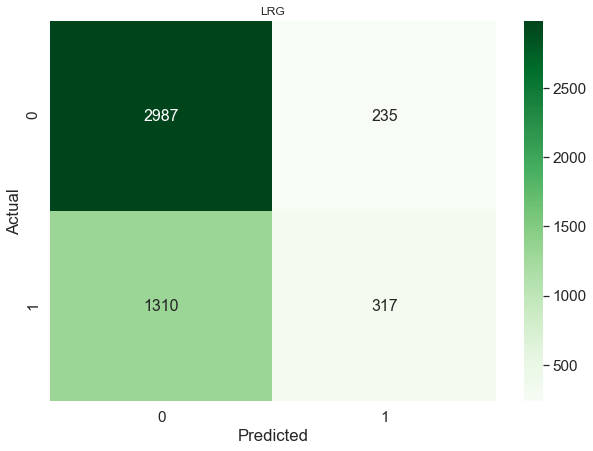

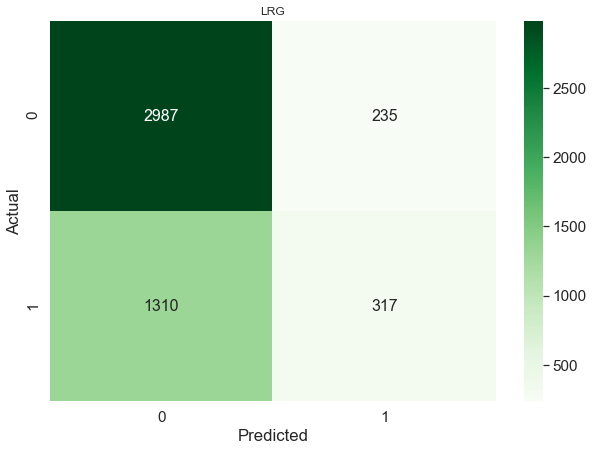

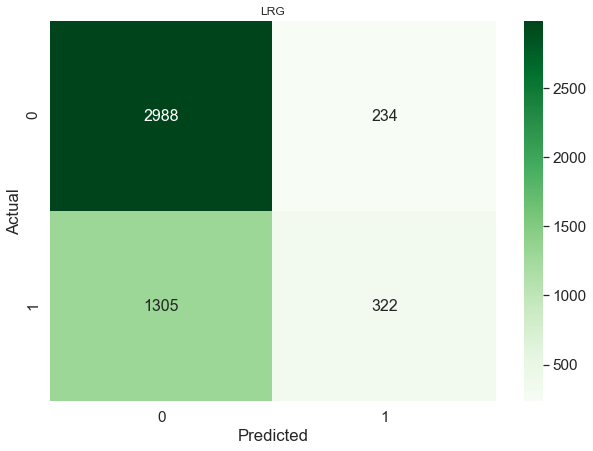

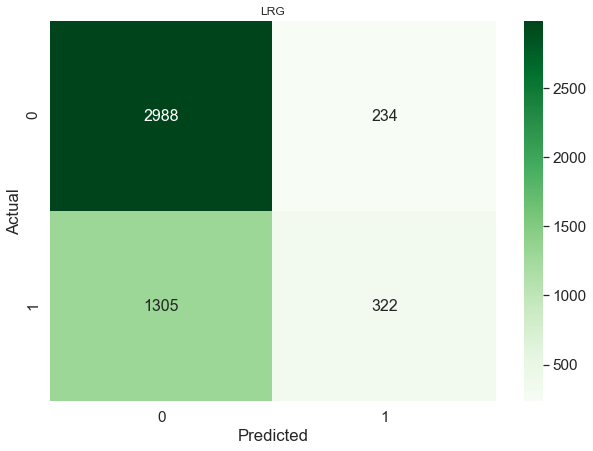

In [8]:
# L1 and L2 Log reg
auc_ls = []
f1_ls = []
for i in ["l1", "l2"]:
    lrg_model = LogisticRegression(solver = "liblinear", penalty = i)
    lrg_model.fit(X_train, y_train)
    auc_ls.append(print_metrics(X_test, y_test, lrg_model, "LRG")[2])
    f1_ls.append(print_metrics(X_test, y_test, lrg_model, "LRG")[3])
print(auc_ls)
print(f1_ls)

[1.1 1. ]
[0.1  0.14]


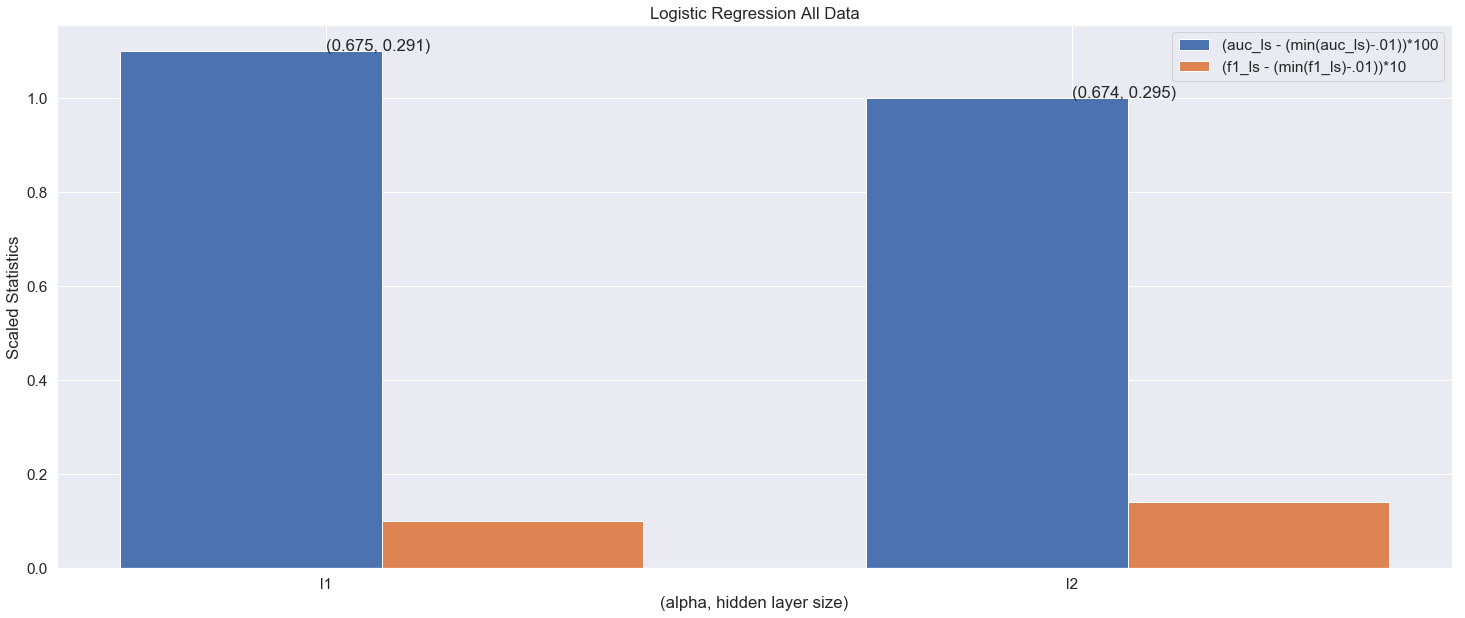

In [12]:
# Scale for plot
scale_auc_ls = (auc_ls - (min(auc_ls)-.01))*100
print(scale_auc_ls)
scale_f1_ls = (f1_ls - (min(f1_ls)-.01))*10
print(scale_f1_ls)

# Plot
n_combos = 2
index = np.arange(n_combos)
axes = plt.gca()
bar_width = .35

aucs = plt.bar(index, scale_auc_ls, bar_width, label = "(auc_ls - (min(auc_ls)-.01))*100")
f1s = plt.bar(index+bar_width, scale_f1_ls, bar_width, label = "(f1_ls - (min(f1_ls)-.01))*10")

plt.xticks(index+.1, ["l1", "l2"])
for i, v in enumerate(scale_auc_ls):
    plt.text(i + .1, max(scale_auc_ls[i], scale_f1_ls[i]), str((auc_ls[i], f1_ls[i])))

plt.xlabel("(alpha, hidden layer size)")
plt.ylabel("Scaled Statistics")
plt.title("Logistic Regression All Data")
plt.legend()

In [10]:
lrg_model.predict_proba(X_wimby_2019)

array([[0.89645558, 0.10354442],
       [0.57774201, 0.42225799],
       [0.71974574, 0.28025426],
       [0.75096205, 0.24903795],
       [0.82494347, 0.17505653],
       [0.88004366, 0.11995634],
       [0.79408223, 0.20591777],
       [0.76026079, 0.23973921],
       [0.78849647, 0.21150353],
       [0.6039139 , 0.3960861 ],
       [0.77160972, 0.22839028],
       [0.704131  , 0.295869  ],
       [0.69695126, 0.30304874],
       [0.52921225, 0.47078775],
       [0.54786648, 0.45213352],
       [0.57503262, 0.42496738]])